# Data Workflow Project (P1)
**Name:** Christopher Aaron O'Hara

**Dataset:** OpenRCA (AIOps telemetry incidents)  

**Dataset Link:** https://github.com/microsoft/OpenRCA

This notebook implements a complete, reproducible AIOps data workflow. 

## 1) Setup

In [120]:
import importlib.util
import subprocess
import sys
import urllib.request
import warnings
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Bootstrap toggles
AUTO_INSTALL_AIF360 = True
AUTO_DOWNLOAD_DATASET = False
AUTO_DOWNLOAD_OPENRCA_TELECOM = True
AIF360_PACKAGE_SPEC = "aif360==0.6.1"
GDOWN_PACKAGE_SPEC = "gdown>=5.2.0"
DATASET_URL = ""  # Optional direct CSV URL. OpenRCA full dataset is typically downloaded manually from Google Drive.
OPENRCA_TELECOM_ZIP_GDRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"  # Folder or direct file URL.
OPENRCA_TELECOM_ZIP_FILE_ID = "1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe"  # Telecom.zip file id to avoid downloading Bank/Market.
OPENRCA_DRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"
OPENRCA_SYSTEM_PREFERENCE = "Telecom"
data_root_candidates = [Path("data"), Path("P1") / "data"]
DATA_ROOT = next(
    (c for c in data_root_candidates if any((c / "openrca" / "Telecom" / "telemetry").glob("*/metric/*.csv"))),
    next(
        (c for c in data_root_candidates if (c / "openrca" / "Telecom" / "query.csv").exists()),
        next((c for c in data_root_candidates if (c / "openrca").exists()), Path("data")),
    ),
)
OPENRCA_EXTRACT_DIR = DATA_ROOT / "openrca"
DOWNLOADED_OPENRCA_ZIP_PATH = DATA_ROOT / "openrca_telecom.zip"
DOWNLOADED_DATASET_PATH = DATA_ROOT / "openrca" / "Telecom" / "telemetry" / "2020_04_20" / "metric" / "metric_service.csv"

# Telecom-focused ingestion controls
COMBINE_TELECOM_METRIC_FILES = True
TELECOM_METRIC_DAY = "2020_04_20"
TELECOM_METRIC_GLOB = "metric_*.csv"
TELECOM_LOCAL_TIMEZONE = "Asia/Shanghai"

# Subset controls for faster exploratory workflow
SUBSET_ENABLED = True
SUBSET_MAX_ROWS = 50000
SUBSET_RANDOM_STATE = 42
SUBSET_STRATIFY_COLUMN = None  # Example: "service" or "fault_type" if present

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)


def ensure_python_package(module_name: str, package_spec: str, auto_install: bool = False) -> tuple[bool, str]:
    """Ensure a Python package is importable; optionally install it in the active kernel environment."""
    if importlib.util.find_spec(module_name) is not None:
        return True, "already_installed"
    if not auto_install:
        return False, "missing_auto_install_disabled"
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])
        ok = importlib.util.find_spec(module_name) is not None
        return ok, "installed" if ok else "install_failed_import"
    except Exception as exc:
        return False, f"install_error: {exc}"


def maybe_download_dataset(url: str, output_path: Path, auto_download: bool = False) -> tuple[bool, str]:
    """Download a dataset file only when enabled and no local copy exists."""
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if output_path.exists():
        return True, "already_present"
    if not auto_download:
        return False, "download_disabled"
    if not url:
        return False, "missing_dataset_url"
    try:
        urllib.request.urlretrieve(url, output_path)
        return output_path.exists(), "downloaded"
    except Exception as exc:
        return False, f"download_error: {exc}"


def find_openrca_query_csv(base_dir: Path, system_preference: str = "Telecom") -> Path | None:
    """Find OpenRCA query.csv, preferring paths that contain the requested system name."""
    query_files = sorted(base_dir.glob("**/query.csv"), key=lambda x: str(x).lower())
    if not query_files:
        return None
    preferred = [p for p in query_files if system_preference.lower() in str(p).lower()]
    return preferred[0] if preferred else query_files[0]


def maybe_download_and_extract_openrca_zip(
    gdrive_url: str,
    telecom_zip_file_id: str,
    zip_path: Path,
    extract_dir: Path,
    auto_download: bool = False,
    system_preference: str = "Telecom",
) -> tuple[bool, str, Path | None]:
    """Download OpenRCA ZIP from Google Drive and extract query.csv files for ingestion."""
    extract_dir.mkdir(parents=True, exist_ok=True)
    existing_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if existing_query is not None:
        return True, "already_present", existing_query
    if not auto_download:
        return False, "download_disabled", None
    if not gdrive_url and not telecom_zip_file_id:
        return False, "missing_gdrive_url_or_file_id", None

    gdown_ready, gdown_status = ensure_python_package(
        module_name="gdown",
        package_spec=GDOWN_PACKAGE_SPEC,
        auto_install=True,
    )
    if not gdown_ready:
        return False, f"gdown_unavailable:{gdown_status}", None

    try:
        import gdown
    except Exception as exc:
        return False, f"gdown_import_error:{exc}", None

    try:
        zip_path.parent.mkdir(parents=True, exist_ok=True)
        if telecom_zip_file_id:
            downloaded_file = gdown.download(
                id=telecom_zip_file_id,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "telecom_zip_download_failed", None
        elif gdrive_url and "/folders/" in gdrive_url:
            return False, "folder_url_requires_telecom_file_id", None
        else:
            downloaded_file = gdown.download(
                url=gdrive_url,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "zip_download_failed", None
    except Exception as exc:
        return False, f"zip_download_error:{exc}", None

    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
    except Exception as exc:
        return False, f"zip_extract_error:{exc}", None

    extracted_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if extracted_query is None:
        return False, "extracted_but_query_missing", None
    return True, "downloaded_and_extracted", extracted_query


def maybe_subset_dataframe(
    df: pd.DataFrame,
    enabled: bool = True,
    max_rows: int | None = 50000,
    random_state: int = 42,
    stratify_col: str | None = None,
) -> tuple[pd.DataFrame, dict]:
    """Return a reproducible subset for EDA while tracking subset metadata for V&V."""
    metadata = {
        "subset_enabled": enabled,
        "subset_applied": False,
        "original_rows": int(len(df)),
        "subset_rows": int(len(df)),
        "stratified": False,
        "stratify_col": stratify_col,
    }

    if not enabled or max_rows is None or len(df) <= max_rows:
        return df, metadata

    if stratify_col and stratify_col in df.columns and df[stratify_col].nunique(dropna=True) > 1:
        sampled = (
            df.groupby(stratify_col, group_keys=False)
            .apply(lambda part: part.sample(n=max(1, int(round(len(part) * max_rows / len(df)))), random_state=random_state))
        )
        if len(sampled) > max_rows:
            sampled = sampled.sample(n=max_rows, random_state=random_state)
        subset = sampled.reset_index(drop=True)
        metadata["stratified"] = True
    else:
        subset = df.sample(n=max_rows, random_state=random_state).reset_index(drop=True)

    metadata["subset_applied"] = True
    metadata["subset_rows"] = int(len(subset))
    return subset, metadata


aif360_ready, aif360_status = ensure_python_package(
    module_name="aif360",
    package_spec=AIF360_PACKAGE_SPEC,
    auto_install=AUTO_INSTALL_AIF360,
)
openrca_zip_ready, openrca_zip_status, openrca_query_path = maybe_download_and_extract_openrca_zip(
    gdrive_url=OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    telecom_zip_file_id=OPENRCA_TELECOM_ZIP_FILE_ID,
    zip_path=DOWNLOADED_OPENRCA_ZIP_PATH,
    extract_dir=OPENRCA_EXTRACT_DIR,
    auto_download=AUTO_DOWNLOAD_OPENRCA_TELECOM,
    system_preference=OPENRCA_SYSTEM_PREFERENCE,
)
dataset_ready, dataset_status = maybe_download_dataset(
    url=DATASET_URL,
    output_path=DOWNLOADED_DATASET_PATH,
    auto_download=AUTO_DOWNLOAD_DATASET,
)
if openrca_query_path is not None:
    DOWNLOADED_DATASET_PATH = openrca_query_path

try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    AIF360_AVAILABLE = True
except Exception:
    AIF360_AVAILABLE = False

BOOTSTRAP_STATUS = {
    "aif360_status": aif360_status,
    "openrca_zip_status": openrca_zip_status,
    "openrca_zip_ready": openrca_zip_ready,
    "openrca_query_path": str(openrca_query_path) if openrca_query_path is not None else None,
    "dataset_status": dataset_status,
    "download_target": str(DOWNLOADED_DATASET_PATH),
    "openrca_drive_url": OPENRCA_DRIVE_URL,
    "openrca_zip_url": OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    "openrca_zip_file_id": OPENRCA_TELECOM_ZIP_FILE_ID,
    "openrca_system_preference": OPENRCA_SYSTEM_PREFERENCE,
}
print("Bootstrap status:", BOOTSTRAP_STATUS)

Bootstrap status: {'aif360_status': 'already_installed', 'openrca_zip_status': 'already_present', 'openrca_zip_ready': True, 'openrca_query_path': 'data\\openrca\\Telecom\\query.csv', 'dataset_status': 'already_present', 'download_target': 'data\\openrca\\Telecom\\query.csv', 'openrca_drive_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_file_id': '1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe', 'openrca_system_preference': 'Telecom'}


In [121]:
setup_checks = {
    "core_imports_loaded": all(name in globals() for name in ["np", "pd", "plt", "sns", "TSNE", "StandardScaler"]),
    "aif360_available": AIF360_AVAILABLE,
    "matplotlib_backend_ready": "plt" in globals(),
    "bootstrap_status_present": "BOOTSTRAP_STATUS" in globals(),
    "subset_controls_present": all(name in globals() for name in ["SUBSET_ENABLED", "SUBSET_MAX_ROWS", "SUBSET_RANDOM_STATE"]),
    "telecom_bootstrap_controls_present": all(name in globals() for name in ["AUTO_DOWNLOAD_OPENRCA_TELECOM", "OPENRCA_TELECOM_ZIP_GDRIVE_URL", "OPENRCA_TELECOM_ZIP_FILE_ID", "OPENRCA_SYSTEM_PREFERENCE", "COMBINE_TELECOM_METRIC_FILES", "TELECOM_METRIC_DAY"]),
}
print("V&V Setup:", setup_checks)
print("Bootstrap status:", BOOTSTRAP_STATUS)
if not AIF360_AVAILABLE:
    print("AIF360 is not available. Set AUTO_INSTALL_AIF360=True (or install manually) and rerun Setup.")
if not DOWNLOADED_DATASET_PATH.exists():
    print("OpenRCA file missing. Set AUTO_DOWNLOAD_OPENRCA_TELECOM=True and verify OPENRCA_TELECOM_ZIP_FILE_ID, then rerun Setup.")
    print("Alternative: place CSVs under data/openrca/{SYSTEM}/query.csv manually.")
    print(f"Official OpenRCA data folder: {OPENRCA_DRIVE_URL}")

V&V Setup: {'core_imports_loaded': True, 'aif360_available': True, 'matplotlib_backend_ready': True, 'bootstrap_status_present': True, 'subset_controls_present': True, 'telecom_bootstrap_controls_present': True}
Bootstrap status: {'aif360_status': 'already_installed', 'openrca_zip_status': 'already_present', 'openrca_zip_ready': True, 'openrca_query_path': 'data\\openrca\\Telecom\\query.csv', 'dataset_status': 'already_present', 'download_target': 'data\\openrca\\Telecom\\query.csv', 'openrca_drive_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_file_id': '1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe', 'openrca_system_preference': 'Telecom'}


## 2) Ingestion

In [122]:
DATA_DIR = globals().get("DATA_ROOT", Path("data"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

system_name = str(globals().get("OPENRCA_SYSTEM_PREFERENCE", "Telecom"))
system_dir = DATA_DIR / "openrca" / system_name

df_raw = None
DATASET_PATH = None
INGESTION_MODE = None
INGESTION_DETAIL = {}

# Preferred mode: combine all metric CSVs for one telecom day.
metric_day = str(globals().get("TELECOM_METRIC_DAY", "2020_04_20"))
combine_metric_files = bool(globals().get("COMBINE_TELECOM_METRIC_FILES", True))
metric_glob = str(globals().get("TELECOM_METRIC_GLOB", "metric_*.csv"))

if combine_metric_files:
    metric_dir = system_dir / "telemetry" / metric_day / "metric"
    metric_files = sorted(metric_dir.glob(metric_glob), key=lambda x: str(x).lower())
    if metric_files:
        frames = []
        for metric_file in metric_files:
            part = pd.read_csv(metric_file, low_memory=False)
            part["metric_source"] = metric_file.stem
            part["telemetry_day"] = metric_day
            frames.append(part)
        df_raw = pd.concat(frames, ignore_index=True, sort=False)
        DATASET_PATH = metric_dir / metric_glob
        INGESTION_MODE = "combined_metric_files"
        INGESTION_DETAIL = {
            "metric_day": metric_day,
            "metric_files_loaded": len(metric_files),
            "metric_file_names": [m.name for m in metric_files],
        }

# Fallback mode: single-file selection.
if df_raw is None:
    bootstrap_dataset_path = Path(globals().get("DOWNLOADED_DATASET_PATH", system_dir / "query.csv"))
    preferred_metric_csvs = sorted(system_dir.glob("telemetry/*/metric/*.csv"), key=lambda x: str(x).lower())
    preferred_query_csvs = sorted(system_dir.glob("query.csv"), key=lambda x: str(x).lower())
    preferred_record_csvs = sorted(system_dir.glob("record.csv"), key=lambda x: str(x).lower())
    openrca_preferred_paths = [bootstrap_dataset_path] + preferred_metric_csvs + preferred_query_csvs + preferred_record_csvs
    fallback_openrca_csvs = sorted((DATA_DIR / "openrca").glob("**/*.csv"), key=lambda x: str(x).lower())
    generic_csvs = sorted([p for p in DATA_DIR.glob("*.csv")] + [p for p in Path(".").glob("*.csv")], key=lambda x: str(x).lower())
    candidate_csvs = [p for p in openrca_preferred_paths if p.exists()] + [p for p in fallback_openrca_csvs if p not in openrca_preferred_paths] + generic_csvs

    if candidate_csvs:
        DATASET_PATH = candidate_csvs[0]
        df_raw = pd.read_csv(DATASET_PATH, low_memory=False)
        INGESTION_MODE = "single_file"

if df_raw is None:
    SUBSET_METADATA = None
    print("No OpenRCA CSV found. Put files under data/openrca/{SYSTEM}/... and rerun.")
    print("Expected systems: Bank, Telecom, Market/cloudbed-1, Market/cloudbed-2")
else:
    df_raw, SUBSET_METADATA = maybe_subset_dataframe(
        df_raw,
        enabled=SUBSET_ENABLED,
        max_rows=SUBSET_MAX_ROWS,
        random_state=SUBSET_RANDOM_STATE,
        stratify_col=SUBSET_STRATIFY_COLUMN,
    )
    if "metric_source" in df_raw.columns:
        INGESTION_DETAIL["metric_source_distribution"] = df_raw["metric_source"].value_counts(dropna=False).to_dict()
    print(f"Ingestion mode: {INGESTION_MODE}")
    print(f"Loaded dataset source: {DATASET_PATH}")
    print(f"Ingestion detail: {INGESTION_DETAIL}")
    print(f"Subset metadata: {SUBSET_METADATA}")
    print(f"Shape: {df_raw.shape[0]} rows x {df_raw.shape[1]} columns")
    display(df_raw.head())

Ingestion mode: combined_metric_files
Loaded dataset source: data\openrca\Telecom\telemetry\2020_04_20\metric\metric_*.csv
Ingestion detail: {'metric_day': '2020_04_20', 'metric_files_loaded': 5, 'metric_file_names': ['metric_app.csv', 'metric_container.csv', 'metric_middleware.csv', 'metric_node.csv', 'metric_service.csv'], 'metric_source_distribution': {'metric_node': 25703, 'metric_service': 14373, 'metric_middleware': 7986, 'metric_container': 1909, 'metric_app': 29}}
Subset metadata: {'subset_enabled': True, 'subset_applied': True, 'original_rows': 592921, 'subset_rows': 50000, 'stratified': False, 'stratify_col': None}
Shape: 50000 rows x 14 columns


,serviceName,startTime,avg_time,num,succee_num,succee_rate,metric_source,telemetry_day,itemid,name,bomc_id,timestamp,value,cmdb_id
0,NaN,NaN,NaN,NaN,NaN,NaN,metric_middleware,2020_04_20,1.000000e+15,keyspace_hits,ZJ-005-027,1.587332e+12,3.000000,redis_010
1,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,Disk_await,ZJ-001-096,1.587328e+12,1.000000,os_007
2,NaN,NaN,NaN,NaN,NaN,NaN,metric_service,2020_04_20,6.315160e+07,Sess_Active,ZJ-002-013,1.587318e+12,0.100000,db_005
3,NaN,NaN,NaN,NaN,NaN,NaN,metric_container,2020_04_20,1.000000e+15,container_cpu_used,ZJ-004-059,1.587325e+12,34.000000,docker_003
4,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,CPU_system_time,ZJ-001-014,1.587320e+12,0.191776,os_009


In [123]:
if df_raw is None:
    print("V&V Ingestion: pending (dataset missing)")
else:
    time_like_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ["time", "date", "timestamp"])]
    ingestion_checks = {
        "is_dataframe": isinstance(df_raw, pd.DataFrame),
        "row_count_at_least_200": df_raw.shape[0] >= 200,
        "column_count_at_least_5": df_raw.shape[1] >= 5,
        "has_time_like_column": len(time_like_cols) > 0,
        "subset_metadata_present": isinstance(globals().get("SUBSET_METADATA"), dict),
        "subset_applied": bool(globals().get("SUBSET_METADATA", {}).get("subset_applied", False)),
        "ingestion_mode_recorded": "INGESTION_MODE" in globals(),
        "combined_metric_mode_used": globals().get("INGESTION_MODE") == "combined_metric_files",
    }
    print("V&V Ingestion:", ingestion_checks)

V&V Ingestion: {'is_dataframe': True, 'row_count_at_least_200': True, 'column_count_at_least_5': True, 'has_time_like_column': True, 'subset_metadata_present': True, 'subset_applied': True, 'ingestion_mode_recorded': True, 'combined_metric_mode_used': True}


## 3) Cleaning

In [124]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Convert columns to lowercase snake_case for reliable downstream code."""
    cleaned = df.copy()
    cleaned.columns = (
        cleaned.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("-", "_", regex=False)
    )
    return cleaned


def drop_duplicate_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Remove exact duplicate records to avoid duplicated incident evidence."""
    return df.drop_duplicates().copy()


def infer_epoch_unit(series: pd.Series) -> str | None:
    """Infer epoch unit from numeric timestamp magnitude (s/ms/us/ns)."""
    numeric = pd.to_numeric(series, errors="coerce").dropna()
    if numeric.empty:
        return None
    magnitude = numeric.abs().median()
    if magnitude >= 1e17:
        return "ns"
    if magnitude >= 1e14:
        return "us"
    if magnitude >= 1e11:
        return "ms"
    if magnitude >= 1e9:
        return "s"
    return None


def parse_time_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Parse true timestamp/date columns while leaving duration metrics (for example avg_time) numeric."""
    cleaned = df.copy()
    time_like_cols = [
        c for c in cleaned.columns
        if any(k in c for k in ["timestamp", "starttime", "endtime", "datetime", "date", "time"])
    ]
    duration_hints = ["avg_time", "latency", "duration", "elapsed", "response_time", "cost_time", "delay"]

    local_tz = globals().get("TELECOM_LOCAL_TIMEZONE", None)

    for col in time_like_cols:
        if any(hint in col for hint in duration_hints):
            continue

        numeric = pd.to_numeric(cleaned[col], errors="coerce")
        numeric_ratio = float(numeric.notna().mean())
        if numeric_ratio >= 0.95:
            unit = infer_epoch_unit(cleaned[col])
            if unit is not None:
                parsed_numeric = pd.to_datetime(numeric, unit=unit, errors="coerce", utc=True)
                if local_tz:
                    parsed_numeric = parsed_numeric.dt.tz_convert(local_tz)
                cleaned[col] = parsed_numeric.dt.tz_localize(None)
            continue

        parsed = pd.to_datetime(cleaned[col], errors="coerce", utc=True)
        if float(parsed.notna().mean()) >= 0.50:
            if local_tz:
                parsed = parsed.dt.tz_convert(local_tz)
            cleaned[col] = parsed.dt.tz_localize(None)

    return cleaned


def impute_missing_values(df: pd.DataFrame, max_missing_ratio_for_impute: float = 0.40) -> pd.DataFrame:
    """Impute non-structural missing values while preserving high-missing structural columns for honest EDA."""
    cleaned = df.copy()

    num_cols = cleaned.select_dtypes(include=[np.number]).columns
    cat_cols = cleaned.select_dtypes(include=["object", "category", "bool"]).columns

    for col in num_cols:
        if float(cleaned[col].isna().mean()) <= max_missing_ratio_for_impute:
            cleaned[col] = cleaned[col].fillna(cleaned[col].median())

    for col in cat_cols:
        if float(cleaned[col].isna().mean()) <= max_missing_ratio_for_impute and cleaned[col].isna().any():
            mode_vals = cleaned[col].mode(dropna=True)
            if len(mode_vals) > 0:
                cleaned[col] = cleaned[col].fillna(mode_vals.iloc[0])

    return cleaned


def add_telecom_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add telecom-specific derived features used for richer EDA and visualization."""
    enriched = df.copy()

    if "metric_source" in enriched.columns:
        enriched["metric_source"] = enriched["metric_source"].astype(str)

    datetime_cols = enriched.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        ref_col = datetime_cols[0]
        enriched["event_hour"] = enriched[ref_col].dt.hour
        enriched["event_dayofweek"] = enriched[ref_col].dt.dayofweek

    if "value" in enriched.columns:
        value_numeric = pd.to_numeric(enriched["value"], errors="coerce")
        enriched["value_log1p"] = np.log1p(value_numeric.clip(lower=0))

    return enriched

In [125]:
if df_raw is None:
    df_clean = None
    print("Cleaning skipped until dataset is available.")
else:
    df_clean = standardize_column_names(df_raw)
    df_clean = drop_duplicate_rows(df_clean)
    df_clean = parse_time_columns(df_clean)
    df_clean = impute_missing_values(df_clean)
    df_clean = add_telecom_derived_features(df_clean)
    print("Cleaning complete.")
    print(f"Cleaned shape: {df_clean.shape[0]} rows x {df_clean.shape[1]} columns")
    display(df_clean.head())

Cleaning complete.
Cleaned shape: 50000 rows x 17 columns


,servicename,starttime,avg_time,num,succee_num,succee_rate,metric_source,telemetry_day,itemid,name,bomc_id,timestamp,value,cmdb_id,event_hour,event_dayofweek,value_log1p
0,NaN,NaN,NaN,NaN,NaN,NaN,metric_middleware,2020_04_20,1.000000e+15,keyspace_hits,ZJ-005-027,2020-04-20 05:33:32,3.000000,redis_010,5.0,0.0,1.386294
1,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,Disk_await,ZJ-001-096,2020-04-20 04:31:02,1.000000,os_007,4.0,0.0,0.693147
2,NaN,NaN,NaN,NaN,NaN,NaN,metric_service,2020_04_20,6.315160e+07,Sess_Active,ZJ-002-013,2020-04-20 01:31:49,0.100000,db_005,1.0,0.0,0.095310
3,NaN,NaN,NaN,NaN,NaN,NaN,metric_container,2020_04_20,1.000000e+15,container_cpu_used,ZJ-004-059,2020-04-20 03:32:50,34.000000,docker_003,3.0,0.0,3.555348
4,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,CPU_system_time,ZJ-001-014,2020-04-20 02:18:47,0.191776,os_009,2.0,0.0,0.175445


In [126]:
if df_clean is None:
    print("V&V Cleaning: pending (dataset missing)")
else:
    numeric_missing = int(df_clean.select_dtypes(include=[np.number]).isna().sum().sum())
    datetime_cols = df_clean.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        max_1970_ratio = max(float((df_clean[c].dt.year == 1970).mean()) for c in datetime_cols)
    else:
        max_1970_ratio = 0.0
    cleaning_checks = {
        "functions_defined": all(
            fn in globals()
            for fn in ["standardize_column_names", "drop_duplicate_rows", "infer_epoch_unit", "parse_time_columns", "impute_missing_values", "add_telecom_derived_features"]
        ),
        "duplicate_rows_remaining": int(df_clean.duplicated().sum()),
        "numeric_missing_after_cleaning": numeric_missing,
        "datetime_not_mostly_epoch_1970": max_1970_ratio < 0.95,
        "derived_features_present": any(c in df_clean.columns for c in ["event_hour", "event_dayofweek", "value_log1p"]),
    }
    print("V&V Cleaning:", cleaning_checks)

V&V Cleaning: {'functions_defined': True, 'duplicate_rows_remaining': 0, 'numeric_missing_after_cleaning': 249913, 'datetime_not_mostly_epoch_1970': True, 'derived_features_present': True}


## 4) Exploratory Data Analysis (EDA)

In [127]:
def generate_eda_report(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """Build expanded EDA artifacts: quality profile, correlation, moments (mean/skew/kurtosis), and source-level summaries."""
    try:
        summary_stats = df.describe(include="all", datetime_is_numeric=True).transpose()
    except TypeError:
        # Compatibility fallback for pandas versions that do not support datetime_is_numeric.
        summary_stats = df.describe(include="all").transpose()

    missingness = (
        df.isna().sum()
        .rename("missing_count")
        .to_frame()
        .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
        .sort_values("missing_count", ascending=False)
    )

    cardinality = (
        df.nunique(dropna=True)
        .rename("unique_values")
        .to_frame()
        .sort_values("unique_values", ascending=False)
    )

    numeric_df = df.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.loc[:, numeric_df.notna().mean() >= 0.60]

    if numeric_df.empty:
        numeric_corr = pd.DataFrame()
        numeric_moments = pd.DataFrame()
    else:
        numeric_corr = numeric_df.corr(numeric_only=True)
        numeric_moments = pd.DataFrame(
            {
                "count": numeric_df.count(),
                "mean": numeric_df.mean(),
                "median": numeric_df.median(),
                "std": numeric_df.std(),
                "variance": numeric_df.var(),
                "skewness": numeric_df.skew(),
                "kurtosis": numeric_df.kurtosis(),
                "min": numeric_df.min(),
                "q1": numeric_df.quantile(0.25),
                "q3": numeric_df.quantile(0.75),
                "max": numeric_df.max(),
            }
        )
        numeric_moments["iqr"] = numeric_moments["q3"] - numeric_moments["q1"]
        numeric_moments["cv"] = numeric_moments["std"] / numeric_moments["mean"].replace(0, np.nan)
        numeric_moments = numeric_moments.sort_values("std", ascending=False)

    if "metric_source" in df.columns:
        source_breakdown = (
            df["metric_source"].fillna("unknown").astype(str).value_counts().rename_axis("metric_source").to_frame("rows")
        )
    else:
        source_breakdown = pd.DataFrame(columns=["rows"])

    if "metric_source" in df.columns and "value" in df.columns:
        source_value_stats = (
            df.assign(value_numeric=pd.to_numeric(df["value"], errors="coerce"))
            .groupby("metric_source")["value_numeric"]
            .agg(["count", "mean", "std", "min", "max"])
            .rename(columns={"count": "value_count", "mean": "value_mean", "std": "value_std", "min": "value_min", "max": "value_max"})
            .sort_values("value_count", ascending=False)
        )
    else:
        source_value_stats = pd.DataFrame(columns=["value_count", "value_mean", "value_std", "value_min", "value_max"])

    datetime_cols = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        time_coverage = pd.DataFrame(
            {
                "column": datetime_cols,
                "min_time": [df[c].min() for c in datetime_cols],
                "max_time": [df[c].max() for c in datetime_cols],
                "unique_timestamps": [df[c].nunique(dropna=True) for c in datetime_cols],
            }
        )
    else:
        time_coverage = pd.DataFrame(columns=["column", "min_time", "max_time", "unique_timestamps"])

    return {
        "summary_stats": summary_stats,
        "missingness": missingness,
        "cardinality": cardinality,
        "numeric_corr": numeric_corr,
        "numeric_moments": numeric_moments,
        "source_breakdown": source_breakdown,
        "source_value_stats": source_value_stats,
        "time_coverage": time_coverage,
    }

In [128]:
if df_clean is None:
    eda_report = None
    print("EDA skipped until dataset is available.")
else:
    eda_report = generate_eda_report(df_clean)
    print("Summary statistics (top 12 rows):")
    display(eda_report["summary_stats"].head(12))
    print("Missingness (top 12 rows):")
    display(eda_report["missingness"].head(12))
    print("Cardinality (top 12 rows):")
    display(eda_report["cardinality"].head(12))
    print("Numeric moments (mean/std/skewness/kurtosis, top 12 by std):")
    display(eda_report["numeric_moments"].head(12))
    print("Metric source breakdown:")
    display(eda_report["source_breakdown"])
    print("Metric source value stats:")
    display(eda_report["source_value_stats"])
    print("Datetime coverage:")
    display(eda_report["time_coverage"])

Summary statistics (top 12 rows):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
servicename,29,1,osb_001,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starttime,29.0,NaN,NaN,NaN,1587323145517.241455,1587312120000.0,1587318000000.0,1587322980000.0,1587329100000.0,1587333300000.0,6843639.166725
avg_time,29.0,NaN,NaN,NaN,0.490948,0.4183,0.4584,0.4807,0.5171,0.6409,0.050196
num,29.0,NaN,NaN,NaN,506.413793,359.0,452.0,506.0,567.0,615.0,69.658615
succee_num,29.0,NaN,NaN,NaN,506.413793,359.0,452.0,506.0,567.0,615.0,69.658615
succee_rate,29.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0
metric_source,50000,5,metric_node,25703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
telemetry_day,50000,1,2020_04_20,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itemid,50000.0,NaN,NaN,NaN,783960010910483.875,48717836.0,999999996381418.0,999999996431772.0,999999996508318.0,999999998651475.0,411545967802036.8125
name,50000,128,Disk_io_util,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missingness (top 12 rows):


,missing_count,missing_pct
servicename,49971,99.942
avg_time,49971,99.942
num,49971,99.942
succee_num,49971,99.942
succee_rate,49971,99.942
starttime,49971,99.942
timestamp,29,0.058
event_dayofweek,29,0.058
event_hour,29,0.058
cmdb_id,0,0.000


Cardinality (top 12 rows):


,unique_values
timestamp,17072
value_log1p,15380
value,15380
itemid,2428
name,128
bomc_id,128
cmdb_id,55
succee_num,29
starttime,29
num,29


Numeric moments (mean/std/skewness/kurtosis, top 12 by std):


,count,mean,median,std,variance,skewness,kurtosis,min,q1,q3,max,iqr,cv
itemid,50000,7.839600e+14,1.000000e+15,4.115460e+14,1.693701e+29,-1.380022,-0.095542,48717836.0,1.000000e+15,1.000000e+15,1.000000e+15,126900.000000,0.524958
value,50000,6.183931e+07,5.800000e-01,5.420481e+08,2.938161e+17,10.823207,130.766866,0.0,0.000000e+00,3.199201e+01,8.000000e+09,31.992012,8.765429
value_log1p,50000,2.338625e+00,4.574248e-01,4.151096e+00,1.723160e+01,2.837122,8.897365,0.0,0.000000e+00,3.496265e+00,2.280271e+01,3.496265,1.775016
event_hour,49971,2.489984e+00,2.000000e+00,1.712131e+00,2.931394e+00,0.004384,-1.271832,0.0,1.000000e+00,4.000000e+00,5.000000e+00,3.000000,0.687607
event_dayofweek,49971,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN


Metric source breakdown:


,rows
metric_source,
metric_node,25703
metric_service,14373
metric_middleware,7986
metric_container,1909
metric_app,29


Metric source value stats:


,value_count,value_mean,value_std,value_min,value_max
metric_source,,,,,
metric_node,25703,9.998159e+02,1.952488e+04,0.00,6.178360e+05
metric_service,14373,1.085494e+03,2.178980e+04,0.00,9.114520e+05
metric_middleware,7986,3.871681e+08,1.309118e+09,0.00,8.000000e+09
metric_container,1909,1.003562e+01,2.331906e+01,0.00,1.010000e+02
metric_app,29,5.800000e-01,0.000000e+00,0.58,5.800000e-01


Datetime coverage:


,column,min_time,max_time,unique_timestamps
0,timestamp,2020-04-20 00:00:01,2020-04-20 05:59:59,17072


In [129]:
if eda_report is None:
    print("V&V EDA: pending (dataset missing)")
else:
    eda_checks = {
        "eda_function_defined": "generate_eda_report" in globals(),
        "summary_stats_present": "summary_stats" in eda_report,
        "missingness_present": "missingness" in eda_report,
        "cardinality_present": "cardinality" in eda_report,
        "correlation_present": "numeric_corr" in eda_report,
        "numeric_moments_present": "numeric_moments" in eda_report,
        "source_breakdown_present": "source_breakdown" in eda_report,
        "time_coverage_present": "time_coverage" in eda_report,
    }
    print("V&V EDA:", eda_checks)

V&V EDA: {'eda_function_defined': True, 'summary_stats_present': True, 'missingness_present': True, 'cardinality_present': True, 'correlation_present': True, 'numeric_moments_present': True, 'source_breakdown_present': True, 'time_coverage_present': True}


## 5) Visualizations (Telecom-First)

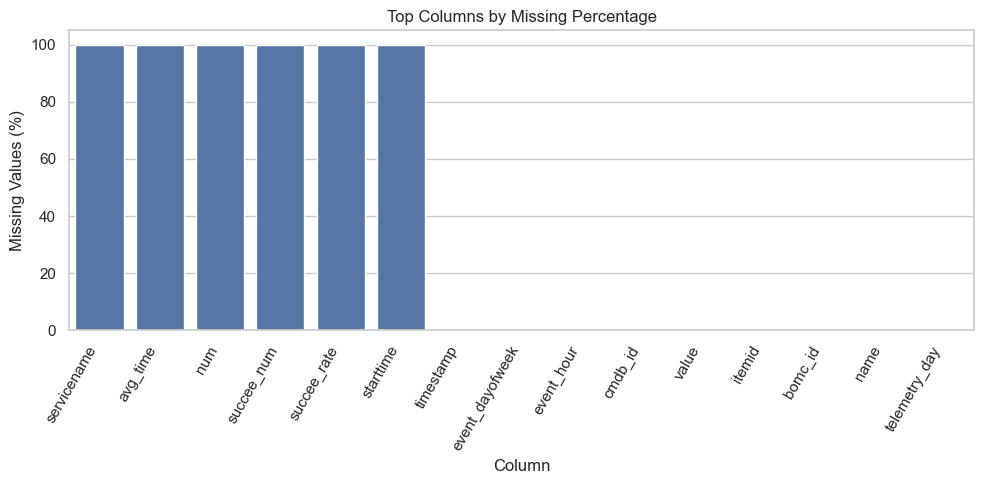

In [130]:
if eda_report is not None:
    top_missing = eda_report["missingness"].head(15).reset_index().rename(columns={"index": "column"})
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_missing, x="column", y="missing_pct")
    plt.title("Top Columns by Missing Percentage")
    plt.xlabel("Column")
    plt.ylabel("Missing Values (%)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 1 skipped: missing EDA report.")

**Figure 1 interpretation:** This identifies data-quality risk areas and helps prioritize cleaning.

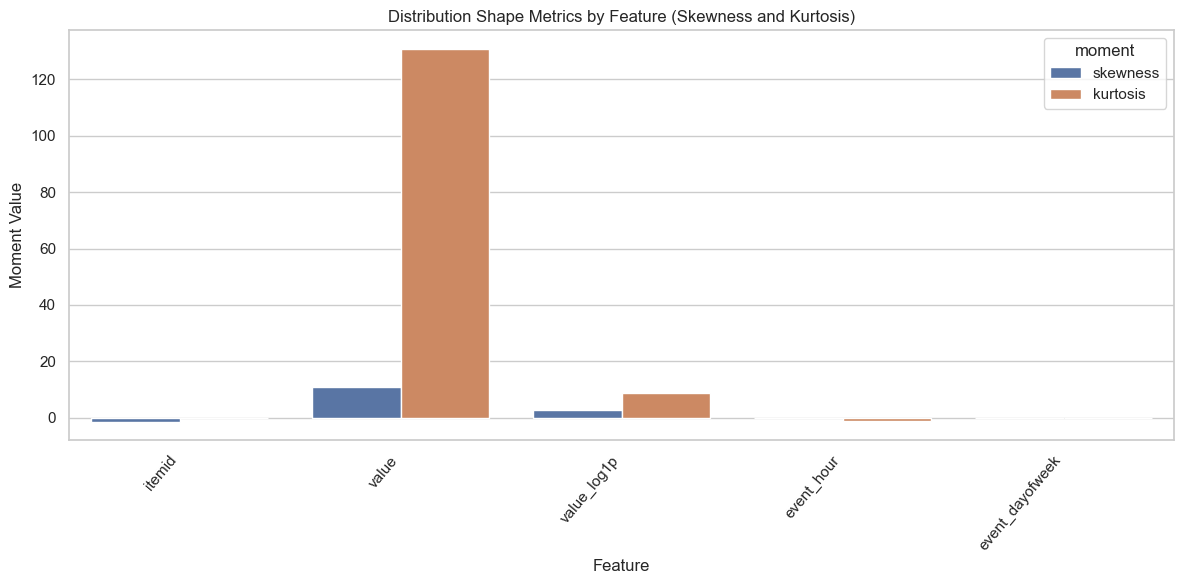

In [131]:
if eda_report is not None and not eda_report["numeric_moments"].empty:
    shape_stats = (
        eda_report["numeric_moments"][["skewness", "kurtosis"]]
        .reset_index()
        .rename(columns={"index": "feature"})
        .head(12)
        .melt(id_vars="feature", var_name="moment", value_name="value")
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(data=shape_stats, x="feature", y="value", hue="moment")
    plt.title("Distribution Shape Metrics by Feature (Skewness and Kurtosis)")
    plt.xlabel("Feature")
    plt.ylabel("Moment Value")
    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 2 skipped: no numeric moments available.")

**Figure 2 interpretation:** Skewness and kurtosis reveal heavy tails and asymmetry that may affect thresholds and anomaly logic.

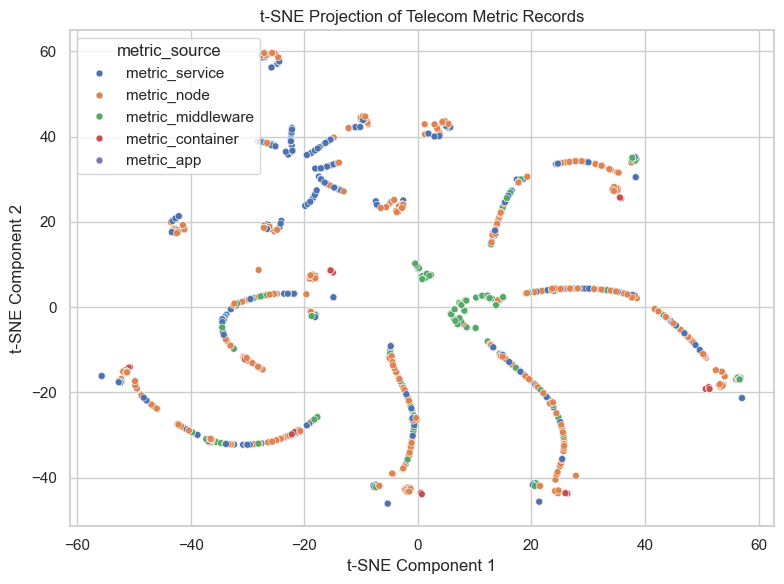

In [132]:
if df_clean is None:
    tsne_frame = None
    print("Visualization 3 skipped: dataset missing.")
else:
    numeric_df = df_clean.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
    numeric_df = numeric_df.loc[:, numeric_df.notna().mean() >= 0.40]
    numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]

    if numeric_df.shape[0] < 10 or numeric_df.shape[1] < 2:
        tsne_frame = None
        print("Visualization 3 skipped: need at least 10 rows and 2 informative numeric features.")
    else:
        sample_n = min(2000, len(numeric_df))
        sampled_numeric = numeric_df.sample(n=sample_n, random_state=42)
        imputer = SimpleImputer(strategy="median")
        X_imputed = imputer.fit_transform(sampled_numeric)

        if np.isnan(X_imputed).any():
            tsne_frame = None
            print("Visualization 3 skipped: NaN values remain after imputation.")
        else:
            X = StandardScaler().fit_transform(X_imputed)

            perplexity = min(30, max(5, sample_n // 20))
            if perplexity >= sample_n:
                perplexity = max(2, sample_n - 1)

            embedding = TSNE(
                n_components=2,
                init="random",
                learning_rate="auto",
                perplexity=perplexity,
                random_state=42,
            ).fit_transform(X)

            tsne_frame = pd.DataFrame({"tsne_1": embedding[:, 0], "tsne_2": embedding[:, 1]}, index=sampled_numeric.index)

            hue_col = None
            label_candidates = [
                "metric_source", "cmdb_id", "name", "servicename", "label", "is_anomaly", "anomaly", "incident", "fault_type", "root_cause_service", "service"
            ]
            for col in label_candidates:
                if col in df_clean.columns and df_clean[col].nunique(dropna=True) <= 10:
                    hue_col = col
                    break

            plt.figure(figsize=(8, 6))
            if hue_col is None:
                sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", s=25)
            else:
                tsne_frame[hue_col] = df_clean.loc[tsne_frame.index, hue_col].astype(str)
                sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", hue=hue_col, s=25)
            plt.title("t-SNE Projection of Telecom Metric Records")
            plt.xlabel("t-SNE Component 1")
            plt.ylabel("t-SNE Component 2")
            plt.tight_layout()
            plt.show()

**Figure 3 interpretation:** t-SNE reveals local structure across combined telecom metric tables and highlights potential source/service clusters.

In [133]:
if df_clean is None:
    print("V&V Visualizations: pending (dataset missing)")
else:
    viz_checks = {
        "viz1_missingness_ready": eda_report is not None,
        "viz2_moments_ready": eda_report is not None and not eda_report["numeric_moments"].empty,
        "viz3_tsne_attempted": tsne_frame is None or isinstance(tsne_frame, pd.DataFrame),
    }
    print("V&V Visualizations:", viz_checks)

V&V Visualizations: {'viz1_missingness_ready': True, 'viz2_moments_ready': True, 'viz3_tsne_attempted': True}


## 6) EDA Bias/Fairness Check with AIF360

In [134]:
def infer_fairness_columns(df: pd.DataFrame) -> tuple[str | None, str | None]:
    """Infer a label column and protected-group proxy for an AIF360 screening audit."""
    label_priority = ["is_anomaly", "anomaly", "incident", "label", "target", "fault_type"]
    group_priority = ["metric_source", "service", "service_name", "team", "system", "cluster", "namespace", "region", "environment", "env", "host", "cmdb_id"]

    label_col = None
    for col in label_priority:
        if col in df.columns and df[col].nunique(dropna=True) >= 2:
            label_col = col
            break
    if label_col is None:
        for col in df.columns:
            if df[col].nunique(dropna=True) == 2:
                label_col = col
                break

    group_col = None
    for col in group_priority:
        if col in df.columns and col != label_col and df[col].nunique(dropna=True) >= 2:
            group_col = col
            break
    if group_col is None:
        for col in df.columns:
            if col == label_col:
                continue
            nunique = df[col].nunique(dropna=True)
            if nunique < 2:
                continue
            if df[col].dtype == "object" or str(df[col].dtype).startswith("category"):
                group_col = col
                break

    return label_col, group_col


def build_fairness_audit_frame(df: pd.DataFrame) -> tuple[pd.DataFrame | None, dict]:
    """Build binary label/protected columns for AIF360, including Telecom fallback labels."""
    meta = {
        "label_strategy": None,
        "label_column_used": None,
        "group_column_used": None,
        "protected_reference_value": None,
        "rows_used": 0,
        "skip_reason": None,
    }

    label_col, group_col = infer_fairness_columns(df)

    label_series = None
    if label_col is not None:
        source = df[label_col]
        source_non_null = source.dropna()
        if source_non_null.nunique() >= 2:
            mode_value = source_non_null.mode(dropna=True).iloc[0]
            label_series = pd.Series(np.nan, index=df.index, dtype="float64")
            label_series.loc[source.notna()] = (source.loc[source.notna()] != mode_value).astype(int)
            meta["label_strategy"] = "inferred_from_existing_column"
            meta["label_column_used"] = label_col

    if label_series is None:
        if "succee_rate" in df.columns:
            rate = pd.to_numeric(df["succee_rate"], errors="coerce")
            if rate.notna().nunique() >= 2:
                label_series = pd.Series(np.nan, index=df.index, dtype="float64")
                label_series.loc[rate.notna()] = (rate.loc[rate.notna()] < 1.0).astype(int)
                if label_series.dropna().nunique() >= 2:
                    meta["label_strategy"] = "fallback_succee_rate_lt_1"
                    meta["label_column_used"] = "succee_rate"
                else:
                    label_series = None

    if label_series is None:
        for col in ["value", "avg_time", "num"]:
            if col not in df.columns:
                continue
            numeric = pd.to_numeric(df[col], errors="coerce")
            if numeric.nunique(dropna=True) < 10:
                continue
            threshold = float(numeric.quantile(0.95))
            candidate = pd.Series(np.nan, index=df.index, dtype="float64")
            candidate.loc[numeric.notna()] = (numeric.loc[numeric.notna()] >= threshold).astype(int)
            if candidate.dropna().nunique() >= 2:
                label_series = candidate
                meta["label_strategy"] = f"fallback_{col}_ge_q95"
                meta["label_column_used"] = col
                break

    if label_series is None:
        meta["skip_reason"] = "no suitable label signal found"
        return None, meta

    if group_col is None:
        meta["skip_reason"] = "no suitable protected-group proxy found"
        return None, meta

    audit_df = pd.DataFrame(
        {
            "label": label_series,
            "group_raw": df[group_col],
        }
    ).dropna()

    if audit_df.empty:
        meta["skip_reason"] = "no overlapping non-null rows for label/group"
        return None, meta

    if audit_df["label"].nunique() < 2:
        meta["skip_reason"] = "label has <2 classes after filtering"
        return None, meta

    if audit_df["group_raw"].nunique() < 2:
        meta["skip_reason"] = "group has <2 classes after filtering"
        return None, meta

    reference_group = audit_df["group_raw"].mode(dropna=True).iloc[0]
    audit_df["protected_group"] = (audit_df["group_raw"] == reference_group).astype(int)

    if audit_df["protected_group"].nunique() < 2:
        meta["skip_reason"] = "binary protected mapping collapsed to one class"
        return None, meta

    audit_df["label"] = audit_df["label"].astype(int)
    meta["group_column_used"] = group_col
    meta["protected_reference_value"] = str(reference_group)
    meta["rows_used"] = int(len(audit_df))

    return audit_df[["label", "protected_group"]], meta



In [135]:
fairness_results = None
fairness_meta = None

if df_clean is None:
    print("AIF360 audit skipped: dataset missing.")
elif not AIF360_AVAILABLE:
    print("AIF360 audit skipped: package unavailable.")
else:
    audit_df, fairness_meta = build_fairness_audit_frame(df_clean)
    if audit_df is None:
        print(f"AIF360 audit skipped: {fairness_meta.get('skip_reason', 'unable to construct audit frame')}.")
    else:
        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=audit_df,
            label_names=["label"],
            protected_attribute_names=["protected_group"],
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{"protected_group": 0}],
            privileged_groups=[{"protected_group": 1}],
        )

        disparate_impact_value = metric.disparate_impact()
        if not np.isfinite(disparate_impact_value):
            disparate_impact_value = np.nan

        fairness_results = {
            **fairness_meta,
            "statistical_parity_difference": float(metric.mean_difference()),
            "disparate_impact": float(disparate_impact_value),
            "label_positive_rate": float(audit_df["label"].mean()),
            "protected_group_rate": float(audit_df["protected_group"].mean()),
        }
        print("AIF360 screening results:")
        print(fairness_results)



AIF360 screening results:
{'label_strategy': 'fallback_value_ge_q95', 'label_column_used': 'value', 'group_column_used': 'metric_source', 'protected_reference_value': 'metric_node', 'rows_used': 50000, 'skip_reason': None, 'statistical_parity_difference': 0.09592785345364395, 'disparate_impact': 29.34061629102311, 'label_positive_rate': 0.05, 'protected_group_rate': 0.51406}


In [136]:
fairness_checks = {
    "aif360_available": AIF360_AVAILABLE,
    "fairness_audit_attempted": df_clean is not None,
    "fairness_results_generated": fairness_results is not None,
    "fairness_strategy_recorded": fairness_results is not None and "label_strategy" in fairness_results,
}
print("V&V AIF360:", fairness_checks)
if fairness_meta is not None:
    print("AIF360 audit metadata:", fairness_meta)



V&V AIF360: {'aif360_available': True, 'fairness_audit_attempted': True, 'fairness_results_generated': True, 'fairness_strategy_recorded': True}
AIF360 audit metadata: {'label_strategy': 'fallback_value_ge_q95', 'label_column_used': 'value', 'group_column_used': 'metric_source', 'protected_reference_value': 'metric_node', 'rows_used': 50000, 'skip_reason': None}


## 7) Summary and Interpretation
TODOs:

- What you learned from the OpenRCA Telecom metric-day analysis.
- Key patterns from Figures 1-3 and why they matter for RCA in telecom systems.
- Which moment statistics (mean, std, skewness, kurtosis, IQR, CV) informed your interpretation.
- Key assumptions made during cleaning, timezone handling, and EDA.
- Limitations and uncertainty in this analysis.
- Bias and data quality risks, including what the AIF360 screening suggests.
- What should be done next before ML/DL modules.

In [137]:
required_cleaning_functions = [
    "standardize_column_names",
    "drop_duplicate_rows",
    "infer_epoch_unit",
    "parse_time_columns",
    "impute_missing_values",
    "add_telecom_derived_features",
]
cleaning_functions_exist = all(fn in globals() for fn in required_cleaning_functions)

final_checks = {
    "cleaning_functions_with_docstrings": (
        cleaning_functions_exist
        and all(bool(globals()[fn].__doc__) and len(globals()[fn].__doc__.strip()) > 0 for fn in required_cleaning_functions)
    ),
    "eda_function_with_docstring": (
        "generate_eda_report" in globals()
        and bool(generate_eda_report.__doc__)
        and len(generate_eda_report.__doc__.strip()) > 0
    ),
    "three_visualizations_configured": True,
    "aif360_section_present": True,
    "required_sections_present": True,
}
print("V&V Final Checklist:", final_checks)

V&V Final Checklist: {'cleaning_functions_with_docstrings': True, 'eda_function_with_docstring': True, 'three_visualizations_configured': True, 'aif360_section_present': True, 'required_sections_present': True}
